# Correcting absolute hydration free energies using support vector machines - null test

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Logger" data-toc-modified-id="Logger-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logger</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Features" data-toc-modified-id="Features-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Labels" data-toc-modified-id="Labels-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Labels</a></span></li><li><span><a href="#Compile-data-sets" data-toc-modified-id="Compile-data-sets-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Compile data sets</a></span><ul class="toc-item"><li><span><a href="#Training-set" data-toc-modified-id="Training-set-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Training set</a></span></li><li><span><a href="#External-testing-set" data-toc-modified-id="External-testing-set-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>External testing set</a></span></li></ul></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Cross validation</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Hyper-parameter-ranges" data-toc-modified-id="Hyper-parameter-ranges-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Hyper-parameter ranges</a></span></li><li><span><a href="#SVR-model" data-toc-modified-id="SVR-model-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>SVR model</a></span></li><li><span><a href="#Training-function" data-toc-modified-id="Training-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Training function</a></span></li><li><span><a href="#Perform-training-per-fold" data-toc-modified-id="Perform-training-per-fold-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Perform training per fold</a></span></li><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Predict-$\Delta-G_{hydr}$" data-toc-modified-id="Predict-$\Delta-G_{hydr}$-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Predict $\Delta G_{hydr}$</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import scipy
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm
from uncertainties import unumpy

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
# Global variables:
model_type = 'null_SVM'
kernel = 'rbf'
label_col = 'Experimental dGhydr (kcal/mol)'
label_u_col = 'uncertainty (kcal/mol)'

# set data processing configurations:
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Ranom number seed

## Path variables

In [3]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output_null/'
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
figures_dr = path + 'figures_null/'
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)
freesolv_loc = datasets_dr + 'freesolv_database.txt'

## Logger

In [4]:
# clean slate output_dr
if os.path.exists(output_dr):
    shutil.rmtree(output_dr)
if not os.path.exists(output_dr):
    os.mkdir(output_dr)

# initiate log file
logging.basicConfig(filename= output_dr + 'dGhydr_' + model_type + '.log',
                    filemode='a',
                    format='%(asctime)s - %(message)s',
                    level=logging.INFO)

logging.info('Starting {}.ipynb.'.format(os.path.abspath('')))
logging.info('\n\nParameters:\n\nn_calls = {}  # gp_minimize\nn_splits = {}  # Kfolds\n'.format(n_calls, n_splits))

## Data preparation

### Features

In [5]:
# load features
reduced_X = pd.read_csv(datasets_dr + 'features_X/reduced_features.csv', index_col='ID').sort_index()

### Labels

In [47]:
# load experimetnal dGhydr column from freesolv
exp_dGhydr = pd.read_csv(filepath_or_buffer=datasets_dr + 'freesolv_database.txt',
                         sep='; ',
                         engine='python',
                         usecols=['compound id (and file prefix)', 'experimental value (kcal/mol)'],
                         index_col='compound id (and file prefix)'
                        ).sort_index()

### Compile data sets

1. Split features and labels into training and testing.
1. Concatenate training features and labels, testing features and labels.

In [7]:
def split_train_test(dataframe):
    """ 
    Returns two dataframes separated into: 
    1) train_df: all entires not submitted under SAMPL4_Guthrie.
    2) test_df: all entries submitted under SAMPL4_Guthrie.
    dataframe: must have FreeSolve 'compound id (and file prefix)' column set as the index column.
    """

    # SAMPl4_Guthrie experimental reference in FreeSolv.
    SAMPL4_Guthrie_ref = 'SAMPL4_Guthrie'
    # Experimental reference column name.
    exp_ref_col = 'experimental reference (original or paper this value was taken from)'
    
    # List comprehension for all non-SAMPL4_Guthrie entries.
    train_ids = [freesolv_df.iloc[i][0]
                 for i in range(len(freesolv_df))
                 if freesolv_df.loc[i, exp_ref_col] != SAMPL4_Guthrie_ref]

    # List comprehension for all SAMPL4_Guthrie entries.
    test_ids = [freesolv_df.iloc[i][0]
                for i in range(len(freesolv_df))
                if freesolv_df.loc[i, exp_ref_col] == SAMPL4_Guthrie_ref]

    train_df = dataframe.drop(test_ids)
    test_df = dataframe.drop(train_ids)

    return train_df, test_df

In [43]:
# split into training and external testing sets
train_X, test_X = split_train_test(reduced_X)
train_y, test_y = split_train_test(label_df)

#### Training set

In [45]:
train_df = pd.concat([train_X, train_y], axis=1)

#### External testing set

In [46]:
test_df = pd.concat([test_X, test_y], axis=1)

### Cross validation

In [11]:
def split_dataset(dataset, n_splits, random_state):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    logging.info('Performing {}-fold cross-validation...'.format(n_splits))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []
    global offset_col_name

    for train, validate in kf.split(dataset):
        training = dataset.iloc[train]
        train_labels = training[label_col]
        train_set = training.drop(label_col, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[label_col]
        validate_set = validating.drop(label_col, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )

    with open(path + 'kfolds.json', "wb") as f:
        pickle.dump(kfolds, f)

    logging.info('Pickled kfolds nested list at {}kfolds.json.'.format(path))
    return kfolds

In [12]:
# call function
kfolds = split_dataset(train_df, n_splits, random_state)

## Training

In [13]:
# init training statistics logger
mae_logger = output_dr + model_type + '_statistics.csv'
with open(mae_logger, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'MAE (kcal/mol)', 'Parameters'])

### Hyper-parameter ranges

In [14]:
# set hyper-parameter ranges, append to list
dim_param_C = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_C")
dim_param_gamma = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_gamma")
dim_param_epsilon = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_epsilon")

# gp_minimize dimensions
dimensions = [dim_param_C, dim_param_gamma, dim_param_epsilon]

### SVR model

In [15]:
def create_model(param_gamma, param_C, param_epsilon):
    """Returns a SVR class instance."""
    
    return SVR(kernel=kernel,
               gamma=param_gamma,
               C=param_C,
               epsilon=param_epsilon,
               verbose=False)

### Training function

In [16]:
class tqdm_skopt(object):
    """tqdm implementation for skopt.gp_minimize"""
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [17]:
def train_model(fold, fold_num):
    """
    1. Unpack data.
    2. Define fitness function for guassian process optmisation.
    3. Decorate fitness with pre-defined hyper-parameter ranges.
    4. Return and pickle final gp_minimize object.
    """
    logging.info('Started training fold {}...'.format(str(fold_num)))

    # retrieve data sets and convert to numpy array
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # define function for gaussian process optimisation
    @use_named_args(dimensions=dimensions)
    def fitness(param_C, param_gamma, param_epsilon):
        """Function for gaussian process optmisation."""

        # create SVR model
        model = create_model(param_C, param_gamma, param_epsilon)

        # train model on training data
        model.fit(train_X, train_y)

        # validate model
        predicted_y = model.predict(validate_X)
        mae = mean_absolute_error(validate_y, predicted_y)

        # update statistics
        with open(output_dr + model_type + '_statistics.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow([fold_num, mae, [param_gamma, param_gamma, param_epsilon]])

        # check if model improves
        global best_mae
        if mae < best_mae:
            # update new model accuracy.
            best_mae = mae
            # overwrite model if mae improves
            pkl_file = output_dr + 'fold_' + str(fold_num) + '_' + model_type + '_model.pickle'
            with open(pkl_file, 'wb') as file: pickle.dump(model, file)
            logging.info('Saved {}.'.format(pkl_file))

        # reset best MAE
        best_mae = np.inf
        
        return mae
    
    # starting parameters
    default_parameters = [1.0, 1.0, 1.0]
    # optimise hyper-parameters
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters,
                                verbose=False,
                                callback=[tqdm_skopt(total=n_calls, desc='Fold {}'.format(fold_num))])

    # save skopt object and analyse in a separate script as
    logging.info('Saved {}fold_{}_gp_minimize_result.pickle.'.format(output_dr, fold_num))

    logging.info('Finished training fold {}: {}.'.format(str(fold_num), search_result.x))
    return search_result

### Perform training per fold

In [18]:
# call train_model save gp_minimize objects to lsit
gp_results = [train_model(fold, fold_num + 1) for fold_num, fold in enumerate(kfolds)]

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be rem

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

### Convergence plot

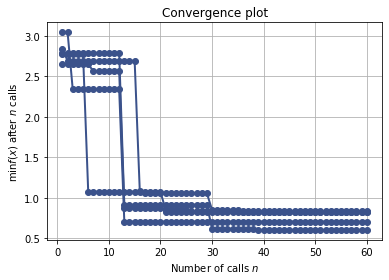

In [19]:
for result in gp_results: plot_convergence(result)
plt.savefig(figures_dr + 'convergence_plot.png')

## External testing

### Predict $\Delta G_{hydr}$

In [20]:
def model_predict(model_num, test_entry):
    """Load model from pickle and return model prediction on a given test_entry."""

    with open(output_dr + 'fold_' + str(model_num) + '_' + model_type + '_model.pickle', 'rb') as f:
        model = pickle.load(f)

    return model.predict(test_entry)

In [49]:
# ML predicted labels nested list per fold
predict_per_fold = [model_predict(fold_num, test_X) for fold_num in range(1, n_splits + 1)]
# average ML predicted labels
predict_y = np.average(predict_per_fold, axis=0)
# convert np array to float
predict_y = [float(x) for x in predict_y]

In [22]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(round(mae, 4), round(r2, 4), round(r_value, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

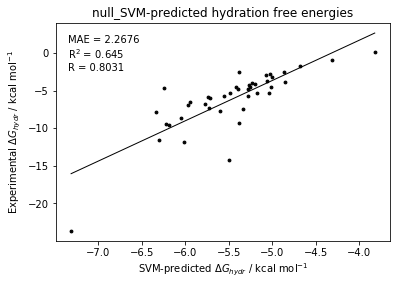

In [23]:
plot_scatter(x=predict_y,
             y=test_y[label_col].tolist(),
             title='{}-predicted hydration free energies'.format(model_type),
             x_label='SVM-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')